In [1]:
import os, glob
import base64
import json
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.colors import ColorConverter
from rdkit import Chem
from rdkit.Chem import Draw

# Display the updated DataFrame in the notebook
from IPython.display import display, HTML

random_seed = 42
data_folder = 'data'

### Load the data

In [2]:
# load the dataframe from pickle files
select_properties_df = pd.read_pickle(os.path.join(data_folder, 'Select_properties.pkl'))
yields_df = pd.read_pickle(os.path.join(data_folder, 'Yields.pkl'))
yield_data_df = pd.read_pickle(os.path.join(data_folder, 'yield_data_df.pkl'))
select_properties_data_df = pd.read_pickle(os.path.join(data_folder, 'select_properties_data_df.pkl'))
select_properties_data_removed_highlycorr_df = pd.read_pickle(os.path.join(data_folder, 'select_properties_data_removed_highlycorr_df.pkl'))
robussness_df = pd.read_pickle(os.path.join(data_folder, 'robustness_screen.pkl'))

In [3]:
display(robussness_df.head(3))

,Additive_smiles,Additive_name,Britton,Maity Stahl (2AP),Maity Stahl (4AP),Golden Stahl,DeLuca,Newkome,Li Xu,Schreiner,% Change LCAP in Chlorination Method
0,FC1=CC=CC=C1,ADT1,20.615155,1.800241,26.916542,9.264748,0.977556,0.939578,2.711945,0.571018,0.0
1,ClC1=CC=CC=C1,ADT2,23.015253,1.422139,31.109814,5.548014,8.991435,1.553725,2.403315,2.308031,0.0
2,BrC1=CC=CC=C1,ADT3,24.801006,4.924011,30.250697,6.665015,14.006317,4.089579,2.409219,1.981927,0.0


### plot the molecules and save the images into a folder

Below are all the common structures and their prefixes (unordered):


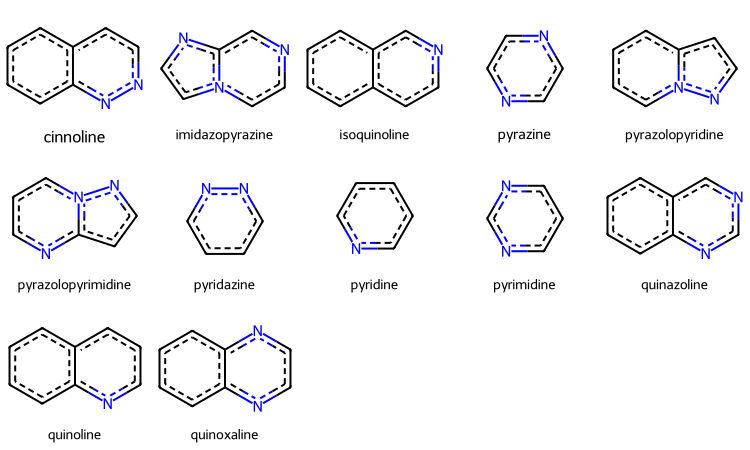

In [4]:
# we have to map to their corresponding core structures
input_common_structure_folder = "common_structure"
common_structure_list = {}
# grep all the cdxml files in the common structure folder
for file in glob.glob("*.cdxml", root_dir=input_common_structure_folder):
    # get the filename without the extension, we will use it as the prefix
    key = file.split(".")[0]
    substructure = Chem.MolsFromCDXMLFile(os.path.join(input_common_structure_folder, file))
    # output to Smarts format
    temp_smarts = Chem.MolToSmarts(substructure[0])
    # reparse the Smarts, this is in case the structure from the cdxml file is not the same as from the SMILES string
    substructure = Chem.MolFromSmarts(temp_smarts)
    # add the substructure to the dictionary
    common_structure_list[key] = substructure
common_structure_prefix = list(common_structure_list.keys())


def print_common_structure_list(common_structure_list):
    # Prepare the list of molecules and corresponding legends (for display under each molecule)
    mols = list(common_structure_list.values())
    legends = list(common_structure_list.keys())
    # Generate a grid image with a fixed number of columns (5 columns)
    img = Chem.Draw.MolsToGridImage(
        mols, molsPerRow=5, subImgSize=(150, 150), legends=legends
    )
    display(img)  # Display the grid of images

print("Below are all the common structures and their prefixes (unordered):")
print_common_structure_list(common_structure_list)

Below are all the common structures and their prefixes (reordered):


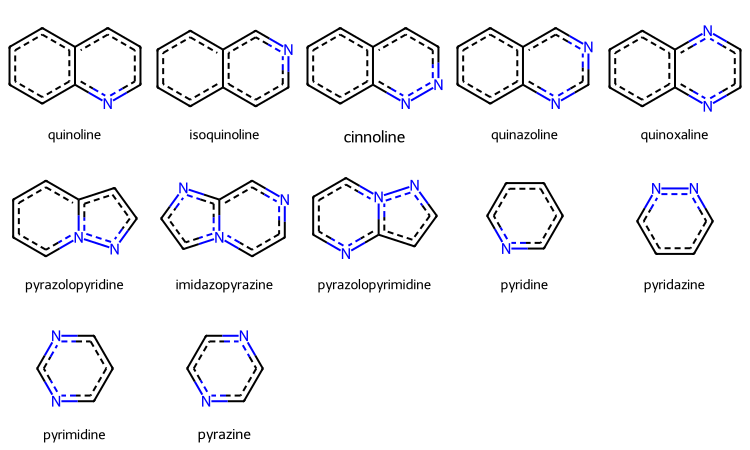

In [5]:
new_common_structure_prefix = [
    # 6 + 6 fused rings
    "quinoline",
    "isoquinoline",
    "cinnoline",
    "quinazoline",
    "quinoxaline",
    # 6 + 5 fused rings
    "pyrazolopyridine",
    "imidazopyrazine",
    "pyrazolopyrimidine",
    # single ring
    "pyridine",
    "pyridazine",
    "pyrimidine",
    "pyrazine",
]
# resort the common_structure_list
# use the reordered list to resort the dictionary
common_structure_list = {
    prefix: common_structure_list[prefix] for prefix in new_common_structure_prefix
}
print("Below are all the common structures and their prefixes (reordered):")
print_common_structure_list(common_structure_list)

In [6]:
# Create a dictionary mapping Compound_Name to RDKit molecule objects
compound_to_mol = {
    row["id"]: Chem.MolFromSmiles(row["SMILES"])
    for _, row in yields_df.iterrows()
}
# create a temp folder to store the images
os.makedirs("images", exist_ok=True)

In [7]:
# Function to draw and save molecule images
def draw_and_save_molecule(drawer, mol, mol_id, output_dir, with_caption: bool = True):
    matcheslist = []
    # first attempt to match the molecule to all the common structures
    for prefix in common_structure_prefix:
        if mol.HasSubstructMatch(common_structure_list[prefix]):
            mol_id = f"{mol_id} ({prefix})"
            # append the submatch atom tuples to the list
            for match in mol.GetSubstructMatches(common_structure_list[prefix]):
                matcheslist.extend(match)
            # force the molecule to have the same orientation as the common structure
            Chem.rdDepictor.Compute2DCoords(common_structure_list[prefix])
            # Chem.rdDepictor.Compute2DCoords(mol)
            Chem.rdDepictor.GenerateDepictionMatching2DStructure(mol, common_structure_list[prefix])
            break
    drawer.ClearDrawing()
    highlight_colors = {atom: ColorConverter().to_rgba("Salmon", alpha=0.8) for atom in matcheslist}
    if with_caption:
        drawer.DrawMolecule(mol, legend=mol_id, highlightAtoms=matcheslist, highlightAtomColors=highlight_colors)
        img_path = os.path.join(output_dir, f"{mol_id}_captioned.png")
    else:
        drawer.DrawMolecule(mol, highlightAtoms=matcheslist, highlightAtomColors=highlight_colors)
        img_path = os.path.join(output_dir, f"{mol_id}.png")
    drawer.FinishDrawing()
    img_data = drawer.GetDrawingText()
    with open(img_path, "wb") as f:
        f.write(img_data)
    return img_path


# Generate molecule images and save the mapping into a dictionary with keys as compound names values as image paths
common_drawer = Draw.rdMolDraw2D.MolDraw2DCairo(200, 200)  # Adjust dimensions if needed
common_drawer_drawOptions = common_drawer.drawOptions()
common_drawer_drawOptionscomicMode = True
common_drawer_drawOptionsaddAtomIndices = True
common_drawer_drawOptionscontinuousHighlight = True
# adjust the font size
common_drawer_drawOptionsbaseFontSize = 1
common_drawer_drawOptionsbondLineWidth = 5
common_drawer_drawOptionshighlightRadius = 0.35
common_drawer_drawOptionshighlightBondWidthMultiplier = 3

mol_image_paths = {name: draw_and_save_molecule(common_drawer, compound_to_mol[name], name, "images", with_caption=False) for name in select_properties_df["Compound_Name"]}
with open("data/mol_image_paths.json", "w") as f:
    json.dump(mol_image_paths, f)
mol_image_data = {name: base64.b64encode(open(path, "rb").read()).decode() for name, path in mol_image_paths.items()}
with open("data/mol_image_data.json", "w") as f:
    json.dump(mol_image_data, f)
mol_image_paths_captioned = {name: draw_and_save_molecule(common_drawer, compound_to_mol[name], name, "images", with_caption=True) for name in select_properties_df["Compound_Name"]}
with open("data/mol_image_paths_captioned.json", "w") as f:
    json.dump(mol_image_paths_captioned, f)
mol_image_data_captioned = {name: base64.b64encode(open(path, "rb").read()).decode() for name, path in mol_image_paths_captioned.items()}
with open("data/mol_image_data_captioned.json", "w") as f:
    json.dump(mol_image_data_captioned, f)

In [8]:
# Create a dictionary mapping Compound_Name to RDKit molecule objects
additive_name_to_mol = {
    row["Additive_name"]: Chem.MolFromSmiles(row["Additive_smiles"])
    for _, row in robussness_df.iterrows()
}
# create a temp folder to store the images
os.makedirs("images", exist_ok=True)

In [9]:
# Function to draw and save molecule images
def draw_and_save_molecule(drawer, mol, mol_id, output_dir, with_caption: bool = True):
    matcheslist = []
    # first attempt to match the molecule to all the common structures
    for prefix in common_structure_prefix:
        if mol.HasSubstructMatch(common_structure_list[prefix]):
            mol_id = f"{mol_id} ({prefix})"
            # append the submatch atom tuples to the list
            for match in mol.GetSubstructMatches(common_structure_list[prefix]):
                matcheslist.extend(match)
            # force the molecule to have the same orientation as the common structure
            Chem.rdDepictor.Compute2DCoords(common_structure_list[prefix])
            # Chem.rdDepictor.Compute2DCoords(mol)
            Chem.rdDepictor.GenerateDepictionMatching2DStructure(mol, common_structure_list[prefix])
            break
    drawer.ClearDrawing()
    highlight_colors = {atom: ColorConverter().to_rgba("Salmon", alpha=0.8) for atom in matcheslist}
    if with_caption:
        drawer.DrawMolecule(mol, legend=mol_id, highlightAtoms=matcheslist, highlightAtomColors=highlight_colors)
        img_path = os.path.join(output_dir, f"{mol_id}_captioned.png")
    else:
        drawer.DrawMolecule(mol, highlightAtoms=matcheslist, highlightAtomColors=highlight_colors)
        img_path = os.path.join(output_dir, f"{mol_id}.png")
    drawer.FinishDrawing()
    img_data = drawer.GetDrawingText()
    with open(img_path, "wb") as f:
        f.write(img_data)
    return img_path


# Generate molecule images and save the mapping into a dictionary with keys as compound names values as image paths
common_drawer = Draw.rdMolDraw2D.MolDraw2DCairo(200, 200)  # Adjust dimensions if needed
common_drawer_drawOptions = common_drawer.drawOptions()
common_drawer_drawOptionscomicMode = True
common_drawer_drawOptionsaddAtomIndices = True
common_drawer_drawOptionscontinuousHighlight = True
# adjust the font size
common_drawer_drawOptionsbaseFontSize = 1
common_drawer_drawOptionsbondLineWidth = 5
common_drawer_drawOptionshighlightRadius = 0.35
common_drawer_drawOptionshighlightBondWidthMultiplier = 3

mol_image_paths = {name: draw_and_save_molecule(common_drawer, additive_name_to_mol[name], name, "images", with_caption=False) for name in robussness_df["Additive_name"]}
with open("data/mol_image_paths.json", "w") as f:
    json.dump(mol_image_paths, f)
mol_image_data = {name: base64.b64encode(open(path, "rb").read()).decode() for name, path in mol_image_paths.items()}
with open("data/mol_image_data.json", "w") as f:
    json.dump(mol_image_data, f)
mol_image_paths_captioned = {name: draw_and_save_molecule(common_drawer, additive_name_to_mol[name], name, "images", with_caption=True) for name in robussness_df["Additive_name"]}
with open("data/mol_image_paths_captioned.json", "w") as f:
    json.dump(mol_image_paths_captioned, f)
mol_image_data_captioned = {name: base64.b64encode(open(path, "rb").read()).decode() for name, path in mol_image_paths_captioned.items()}
with open("data/mol_image_data_captioned.json", "w") as f:
    json.dump(mol_image_data_captioned, f)

In [10]:
yield_columns = yield_data_df.columns

In [11]:
# Build the heatmap
fig = go.Figure(
    data=go.Heatmap(
        z=yields_df[yield_columns].T.to_numpy(),
        x=yields_df["id"],
        y=yield_columns,
        colorscale="Reds",
        colorbar=dict(
            title="Yield",
            dtick=20,
            tickvals=[0, 20, 40, 60, 80, 100],
            ticktext=["0%", "20%", "40%", "60%", "80%", "100%"],
        ),
        text=yields_df[yield_columns].T.to_numpy(),
        texttemplate="%{text:.2f}",
        hovertemplate="""
        Compound ID: %{x}<br>
        Method: %{y}<br>
        Yield: %{text:.2f}%<extra></extra>
        """,
        showscale=True,
    )
)

# Add molecule images to the x-axis
for i, compound_id in enumerate(yields_df["id"]):
    img_path = mol_image_paths[compound_id]  # Path to molecule image
    img = base64.b64encode(open(img_path, "rb").read()).decode()
    fig.add_layout_image(
        dict(
            source=f"data:image/png;base64,{img}",
            xref="x",
            yref="paper",
            x=i,  # X position (aligned to x-axis tick)
            y=1,  # Y position slightly above the plot
            xanchor="center",
            yanchor="bottom",
            sizex=1,  # Adjust size
            sizey=1,  # Adjust size
            sizing="contain",  # Maintain aspect ratio
            layer="above",  # Place above heatmap
        )
    )

# Update layout
fig.update_layout(
    xaxis_title="Compound ID",
    yaxis_title="Method",
    height=len(yield_columns) * 50,
    width=len(yields_df["id"]) * 50,
    xaxis=dict(tickangle=30),
    template="plotly",
)


fig.show()

KeyError: 'Het036'

In [ ]:
# Create the heatmap with controlled subblock ratios and text labels
fig = px.imshow(
    yields_df[yield_columns].T.to_numpy(),
    labels={"x": "Compound ID", "y": "Method", "color": "Yield"},
    x=yields_df["id"],
    y=yield_columns,
    text_auto=".2f",  # Add text labels automatically
    color_continuous_scale="Reds",  # Set the color scale
    title="Yields Across Different Methods",
)

# Add molecule images to the x-axis
for i, compound_id in enumerate(yields_df["id"]):
    img_path = mol_image_paths[compound_id]  # Path to molecule image
    img = base64.b64encode(open(img_path, "rb").read()).decode()
    fig.add_layout_image(
        dict(
            source=f"data:image/png;base64,{img}",
            xref="x",
            yref="paper",
            x=i,  # X position (aligned to x-axis tick)
            y=1,  # Y position slightly above the plot
            xanchor="center",
            yanchor="bottom",
            sizex=1,  # Adjust size
            sizey=1,  # Adjust size
            sizing="contain",  # Maintain aspect ratio
            layer="above",  # Place above heatmap
        )
    )

fig.update_layout(
    xaxis_title="Compound ID",
    yaxis_title="Method",
    height=len(yield_columns) * 50,
    width=len(yields_df) * 50,
    xaxis=dict(tickangle=30),
    template="plotly",
    # set font size
    font=dict(size=12, family="Arial", color="black", weight="bold"),
    # no tite
    title=None,
)


fig.update_coloraxes(colorbar_orientation="v")

# Display the figure
fig.show()

In [ ]:
yield_data_series = yield_data_df.stack()
fig = px.histogram(
    yield_data_series,
    nbins=25,
    title="Distribution of Yields Across All Methods",
    labels={"value": "Yield (%)", "count": "Frequency"},
    text_auto=True,
    color_discrete_sequence=["Red"],
)
fig.update_layout(
    bargap=0.1,
    width=1000,
    height=500,
    grid=dict(columns=2, rows=1),
    template="plotly_white",
    # no legend
    showlegend=False,
    # bold the font
    font=dict(size=16, family="Arial", color="black", weight="bold"),
    font_family="Arial",
    title=None,
)
fig.show()

In [ ]:
yield_data_series = yield_data_df.stack()
fig = px.histogram(
    yield_data_series,
    nbins=25,
    title="Distribution of Yields Across All Methods",
    labels={"value": "Yield (%)", "count": "Frequency"},
    text_auto=".1f",
    color_discrete_sequence=["Red"],
    histnorm="percent",
)
fig.update_layout(
    bargap=0.1,
    width=1000,
    height=500,
    grid=dict(columns=2, rows=1),
    template="plotly_white",
    # no legend
    showlegend=False,
    # bold the font
    font=dict(size=16, family="Arial", color="black", weight="bold"),
    font_family="Arial",
    title=None,
)
fig.show()

In [ ]:
import plotly.graph_objects as go

# Prepare the data
yield_data_series = yield_data_df.stack()

# Compute histograms for counts and percentages
hist_counts = go.Histogram(
    x=yield_data_series,
    nbinsx=25,
    name="Raw Count",
    marker=dict(color="LightSalmon"),
    texttemplate="%{y}",  # Add text for counts
    textposition="outside",  # Position the text on top of the bars
    opacity=1,
)

hist_percentage = go.Histogram(
    x=yield_data_series,
    nbinsx=25,
    name="Percentage",
    marker=dict(color="DeepSkyBlue"),
    histnorm="percent",
    texttemplate="%{y:.1f}",  # Add text for percentages
    textposition="outside",  # Position the text on top of the bars
    opacity=1,
)

# Create the figure
fig = go.Figure()

# Add both histograms
fig.add_trace(hist_counts)
fig.add_trace(hist_percentage)

# Configure layout
fig.update_layout(
    title=None,
    xaxis=dict(title="Yield (%)"),
    yaxis=dict(title="Count/Percentage"),
    barmode="group",  # Display bars side by side
    bargap=0.1,
    width=1500,
    height=500,
    template="plotly_white",
    showlegend=True,  # Show the legend
    font=dict(size=24, family="Arial", color="black", weight="bold"),
    # increase margin
    margin=dict(l=50, r=50, t=50, b=50),
    legend=dict(
        x=1,  # Position legend at the right edge
        y=1,  # Position legend at the top edge
        xanchor="right",  # Align legend to the right
        yanchor="top",  # Align legend to the top
        bgcolor="rgba(255, 255, 255, 1)",  # Transparent background
        bordercolor="Gray",  # Set border color
        borderwidth=2,  # Set border width
    ),
)

# Show the figure
fig.show()

In [ ]:
def plot_column_by_compound(
    df: pd.DataFrame, sort_by_column: str, mol_image_paths: dict
):
    # Extract data
    x = df["Compound_Name"]
    y = df[sort_by_column]

    # Create a bar chart
    fig = px.bar(
        title=f"{sort_by_column} by Compound",
        x=x,
        y=y,
        # create a constant color dataframe
        # color = pd.Series([1]*len(x), name='color'),
        # color_continuous_scale="Reds",
        # color_continuous_midpoint=0.5,
        text=y,
        text_auto=".2f",
        labels={
            "x": "Molecule",
            "y": sort_by_column,
        },
    )
    fig.update_xaxes(tickvals=x, title_text="Molecule")
    fig.update_traces(
        marker_color="LightSalmon",
        textfont=dict(size=16),  # Set text size specifically for the text on bars
        textposition="inside",
    )

    # Add molecule images to the x-axis
    for compound_name, y_value in zip(df["Compound_Name"], y):
        img_path = mol_image_paths[compound_name]
        img = base64.b64encode(open(img_path, "rb").read())
        fig.add_layout_image(
            source=f"data:image/png;base64,{img.decode()}",
            xref="x",
            yref="y",
            x=compound_name,
            y=y_value,
            xanchor="center",
            yanchor="bottom" if y_value >= 0 else "top",
            sizex=1,  # Adjust size of the image
            sizey=10,
            sizing="contain",
            layer="above",
        )

    fig.update_layout(
        # set the range
        yaxis_range=[min(y) - 0.6, max(y) + 0.6],
        bargap=0.15,
        height=len(y) * 30,
        width=len(x) * 60,
        template="plotly_white",
        xaxis=dict(tickangle=30),
        font=dict(size=24, family="Arial", color="black", weight="bold"),
        # disable colorbar
        # coloraxis_showscale=False,
    )

    # Show the chart
    return fig

In [ ]:
""" for sort_by_column in select_properties_df.select_dtypes(include="number").columns:
    # Sort compounds based on the sort_by_column column
    sorted_compounds = select_properties_df.sort_values(sort_by_column)

    # Add the new column with image paths as HTML <img> tags
    sorted_compounds.insert(
        1,  # Insert as the second column
        "Molecule_Image",
        sorted_compounds["Compound_Name"].map(
            lambda name: f'<img src="{mol_image_paths.get(name)}" width="100"/>'
        ),
    )

    # Render as HTML with the image paths
    # display(HTML(sorted_compounds.head(3).to_html(escape=False)))

    fig = plot_column_by_compound(sorted_compounds, sort_by_column, mol_image_paths)
    # save to html and open in browser
    fig.write_html("temp.html", auto_open=True) """

In [ ]:
select_properties_df.columns

In [ ]:
# Sort compounds based on the sort_by_column column
sort_by_column = "SASA_sphericity_Boltz_openshell"
sorted_compounds = select_properties_df.sort_values(sort_by_column)

# Add the new column with image paths as HTML <img> tags
sorted_compounds.insert(
    1,  # Insert as the second column
    "Molecule_Image",
    sorted_compounds["Compound_Name"].map(
        lambda name: f'<img src="{mol_image_paths.get(name)}" width="100"/>'
    ),
)

# Render as HTML with the image paths
display(HTML(sorted_compounds.head(3).to_html(escape=False)))

# fig = plot_column_by_compound(sorted_compounds, sort_by_column, mol_image_paths)
# save to html and open in browser
# fig.write_html("temp.html", auto_open=True)